In [1]:
import cv2 
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import uuid

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten


### Preparing data

#### Preparing negative data

In [2]:
base_path = "archive/lfw-deepfunneled/lfw-deepfunneled"

In [3]:
for dir in os.listdir(base_path):
    dir_path = os.path.join(base_path, dir)
    if os.path.isdir(dir_path):  
        for file in os.listdir(dir_path):
            ex_path = os.path.join(dir_path, file)
            new_path = os.path.join("data/negative", file)
            os.replace(ex_path, new_path)

#### Preparing Positive and Target data

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[500:500+250,1000:1000+250, :]
    
    # Collect target 
    if cv2.waitKey(1) & 0XFF == ord('t'):
        # Create the unique file path 
        imgname = os.path.join("data/target", '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join("data/positive", '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


#### Get data directory

In [2]:
target = tf.data.Dataset.list_files("data/target/*.jpg").take(550)
positive = tf.data.Dataset.list_files("data/positive/*.jpg").take(550)
negative = tf.data.Dataset.list_files("data/negative/*.jpg").take(550)


In [21]:
test = target.as_numpy_iterator()
print(test.next())

b'data/target/45b3a012-533c-11f0-a657-eead538d095b.jpg'


### Preprocessing

In [4]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    img = tf.image.resize(img, (105,105))
    img = img / 255.0

    return img

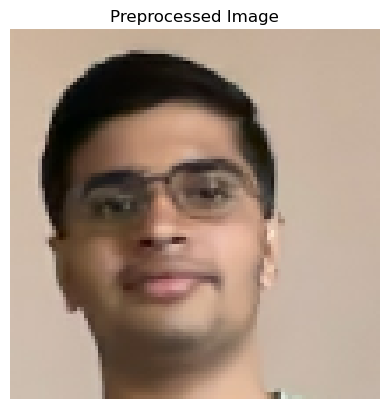

In [22]:
# Test preprocessing on a sample image
img = preprocess('data/target/45b3a012-533c-11f0-a657-eead538d095b.jpg')
plt.imshow(img)
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()

#### Label our data

In [23]:
positives = tf.data.Dataset.zip((target, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(target)))))
negatives = tf.data.Dataset.zip((target, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(target)))))
data = positives.concatenate(negatives)

In [30]:
# Check a sample from the labeled data
samples = data.as_numpy_iterator()
example = samples.next()
print("Example data structure:", example)

Example data structure: (b'data/target/422958ec-533c-11f0-a657-eead538d095b.jpg', b'data/positive/395a1cbe-533d-11f0-a657-eead538d095b.jpg', 1.0)


### Build Train and Test Partition

In [25]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

Label: 1.0


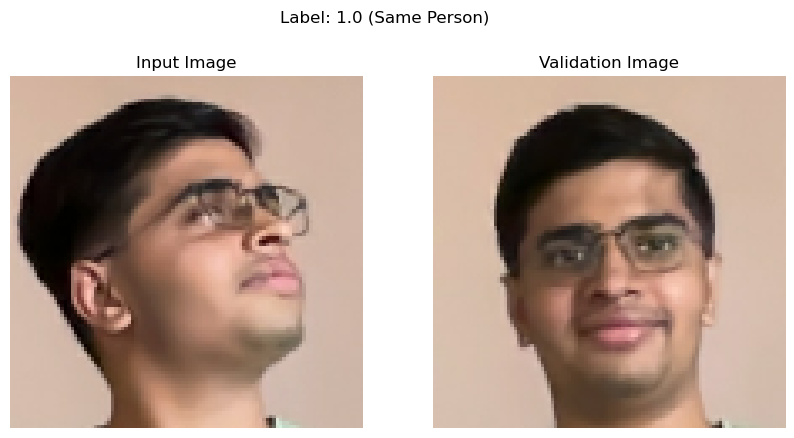

In [31]:
# Test preprocessing on a pair
res = preprocess_twin(*example)
print(f"Label: {res[2]}")

# Visualize the pair
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(res[0])
axes[0].set_title("Input Image")
axes[0].axis('off')
axes[1].imshow(res[1])
axes[1].set_title("Validation Image")
axes[1].axis('off')
plt.suptitle(f"Label: {res[2]} ({'Same Person' if res[2] == 1.0 else 'Different Person'})")
plt.show()

In [32]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

2025-06-27 16:00:34.278041: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


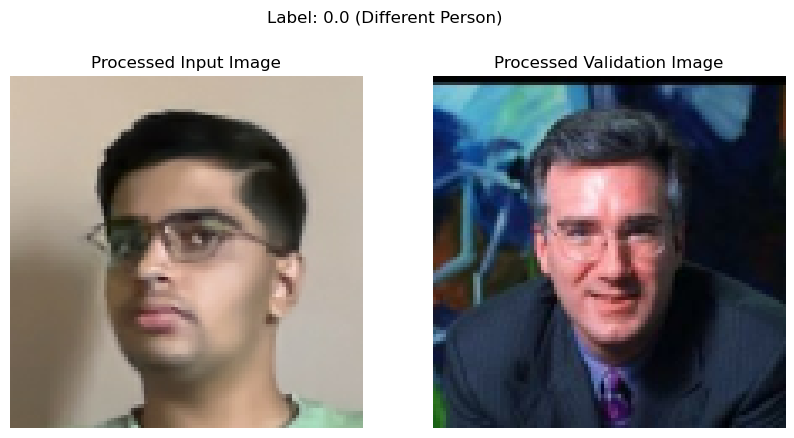

In [43]:
# Visualize samples from processed data
samples = data.as_numpy_iterator()
s = samples.next()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(s[0])
axes[0].set_title("Processed Input Image")
axes[0].axis('off')
axes[1].imshow(s[1])
axes[1].set_title("Processed Validation Image")
axes[1].axis('off')
plt.suptitle(f"Label: {s[2]} ({'Same Person' if s[2] == 1.0 else 'Different Person'})")
plt.show()

In [44]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### Model Engineering

In [45]:
def make_embeddings():
    inp = Input(shape = (105,105,3), name = "input_image")

    # First Block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Fourth Block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=inp, outputs=d1, name='embedding')

embedding = make_embeddings()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

#### Distance layer

In [46]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

#### Siamese model


In [47]:
input_image = Input(name='input_img', shape=(105,105,3))
print(embedding(input_image))

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_9>


In [48]:
def make_siamese_model(): 
    
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])

    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_network = make_siamese_model()
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

#### Training


In [49]:
# Compile the model for training with Keras fit
siamese_network.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy()]
)

# Prepare data for Keras
def format_for_keras(input_img, validation_img, label):
    return {'input_img': input_img, 'validation_img': validation_img}, label

train_data_keras = train_data.map(format_for_keras)
test_data_keras = test_data.map(format_for_keras)


In [50]:
# Callbacks for training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/siamese_ckpt.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# Train the model
history = siamese_network.fit(
    train_data_keras,
    validation_data=test_data_keras,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1751020572.600142 2459239 service.cc:145] XLA service 0x17c4605c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751020572.600370 2459239 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1751020572.783514 2459239 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - binary_accuracy: 0.5720 - loss: 0.5294 - precision: 0.7757 - recall: 0.1263
Epoch 1: val_loss improved from inf to 0.24250, saving model to ./training_checkpoints/siamese_ckpt.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - binary_accuracy: 0.5742 - loss: 0.5276 - precision: 0.7796 - recall: 0.1310 - val_binary_accuracy: 0.9061 - val_loss: 0.2425 - val_precision: 0.9036 - val_recall: 0.9091
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.8953 - loss: 0.2577 - precision: 0.9396 - recall: 0.8620
Epoch 2: val_loss improved from 0.24250 to 0.13240, saving model to ./training_checkpoints/siamese_ckpt.weights.h5
49/49 ━━━━━━━━━━━━━━━━━━━━ 274s 6s/step - binary_accuracy: 0.8958 - loss: 0.2567 - precision: 0.9400 - recall: 0.8623 - val_binary_accuracy: 0.9545 - val_loss: 0.1324 - val_precision: 0.9871 - val_recall: 0.9217
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.9493 - loss: 0.1382 - precision: 0.98

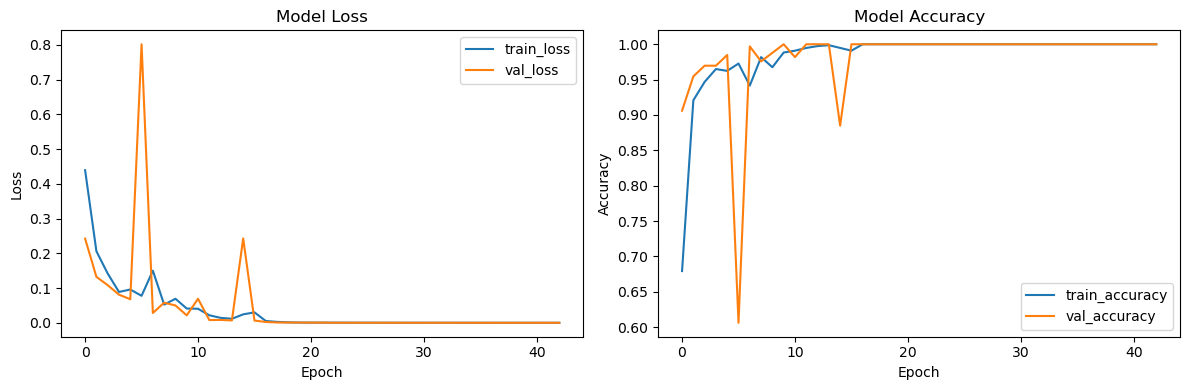

In [52]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='train_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
# Evaluate model on test set
from tensorflow.keras.metrics import Precision, Recall

# Initialize metrics
precision = Precision()
recall = Recall()

# Iterate over test set and update metrics
for batch in test_data_keras:
    X, y_true = batch
    y_pred = siamese_network.predict(X)
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)

print(f"Test Precision: {precision.result().numpy():.4f}")
print(f"Test Recall: {recall.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
Test Precision: 1.0000
Test Recall: 1.0000


2025-06-27 20:44:22.129245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [51]:
# Save the model
siamese_network.save('siamese_network.keras')
siamese_network.save('siamese_network.h5')
